In [1]:
from keras.models import Sequential
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

2023-12-02 17:30:57.260055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = np.load('/Users/opopligher1996/workspace/master/BusinessIntelligenceTechniquesAndApplications_DSME6756/project/DSME6756_Group_Project/Section_1/windspeed_timeseries/dataset/image_sequence/images.npy')
print('Original size:',data.shape)

# Drop last three for convinence
new_data_train = data[:-1]
new_data_test = data[:-1]
print('New train & test size:',new_data_train.shape,new_data_test.shape)

Original size: (41, 250, 329, 1)
New train & test size: (40, 250, 329, 1) (40, 250, 329, 1)


In [3]:
# reshape to (batch_size, time_steps, height, width, filters (layers)
new_data_train = np.reshape(new_data_train,(8,5,250,329,1))
new_data_test = np.reshape(new_data_train,(8,5,250,329,1))

new_data_train = new_data_train / 255
new_data_test = new_data_test / 255

print('New train & test size:',new_data_train.shape,new_data_test.shape)

New train & test size: (8, 5, 250, 329, 1) (8, 5, 250, 329, 1)


In [4]:
from keras.metrics import CosineSimilarity
seq = Sequential()

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 250, 329, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(5, 5),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

seq.compile(loss='binary_crossentropy', optimizer='adam',metrics=[CosineSimilarity()])

seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 250, 329,    59200     
                             40)                                 
                                                                 
 batch_normalization (Batch  (None, None, 250, 329,    160       
 Normalization)              40)                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 250, 329,    320160    
                             40)                                 
                                                                 
 batch_normalization_1 (Bat  (None, None, 250, 329,    160       
 chNormalization)            40)                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 250, 329,    3

In [ ]:
history = seq.fit(new_data_train, new_data_test, batch_size=2, epochs=100, validation_split=0.1)

Epoch 1/100


In [15]:
seq.save('/Users/opopligher1996/workspace/master/BusinessIntelligenceTechniquesAndApplications_DSME6756/images_seq.h5')
print("model saved")

model saved


/Users/opopligher1996/anaconda3/envs/DSME6756/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
which = 7 # record to inspect
track = new_data_train[which][:3, ::, ::, ::]

In [19]:
track.shape, track[np.newaxis, ::, ::, ::, ::].shape

((3, 250, 329, 1), (1, 3, 250, 329, 1))

In [20]:
for j in range(6):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::]) # (1, 3, 245, 329, 1)
    new = new_pos[::, -1, ::, ::, ::] # (1, 245, 329, 1)
    track = np.concatenate((track, new), axis=0) # adds +1 to the first dimension in each loop cycle

1/1 [==============================] - 23s 23s/step


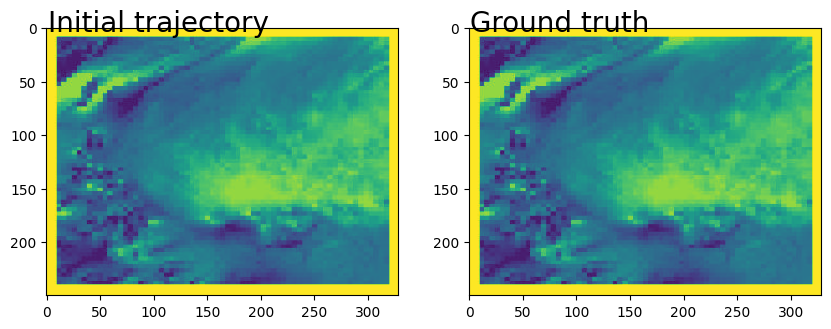

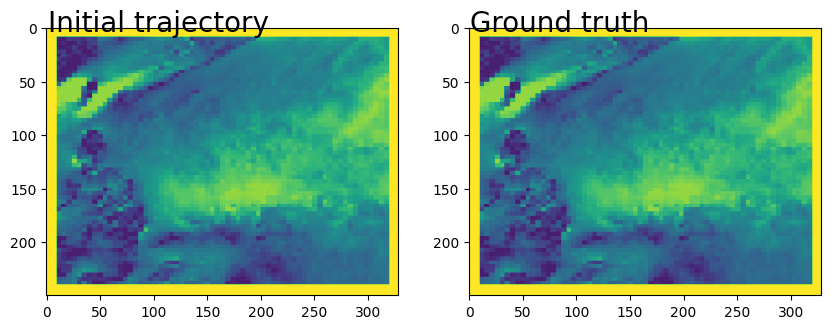

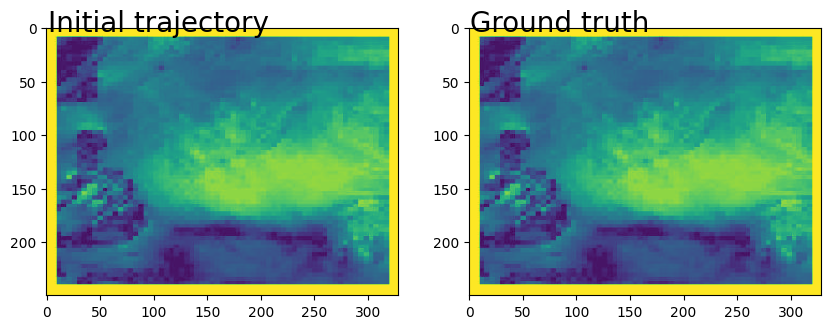

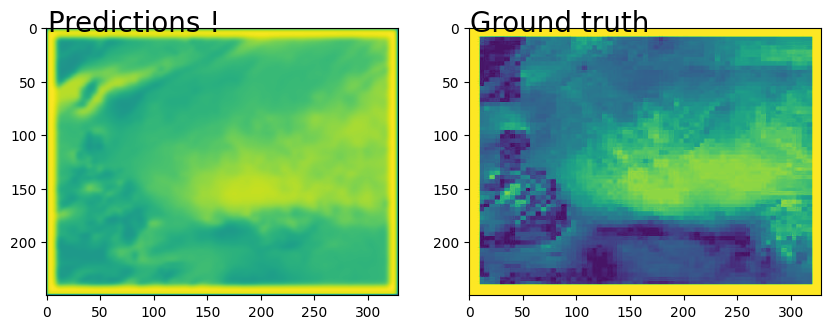

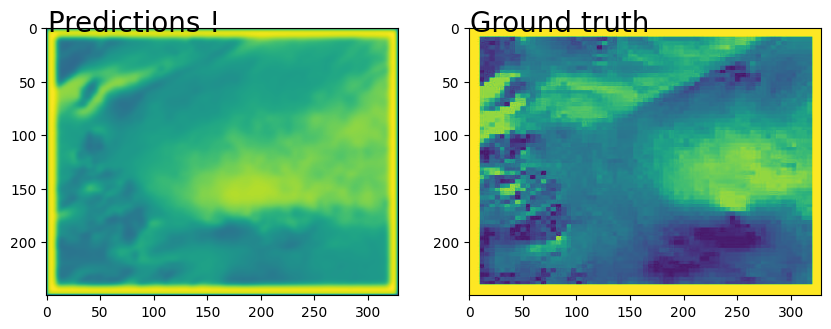

In [21]:
track2 = new_data_train[which][::, ::, ::, ::]

for i in range(5):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 3:
        ax.text(1, 3, 'Predictions !', fontsize=20)#, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 3:
        toplot = new_data_test[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    #plt.savefig('%i_animate.png' % (i + 1))